# Change Detection with Instance Segmentation

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/change_detection.ipynb)

This notebook demonstrates the change detection functionality in GeoAI, which provides instance segmentation and confidence scoring for individual change objects.

The change detection functionality builds upon the [torchange](https://github.com/Z-Zheng/pytorch-change-models) package developed by Dr. Zhuo Zheng. We have made it much easier to analyze remote sensing imagery and visualize the results.

## Overview

The change detection system provides:

- **Instance Segmentation**: Each change object gets a unique ID
- **Confidence Scores**: Individual confidence values for each detected instance
- **Proper GeoTIFF Output**: Maintains spatial reference information

## Key Features

- Instance-level change detection with unique IDs
- Confidence scoring for quality assessment
- Support for large GeoTIFF files
- Comprehensive analysis capabilities

## Install packages

In [15]:
%pip install geoai-py

## Import libraries

In [16]:
import geoai
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from geoai.change_detection import ChangeDetection

## Setup

In [17]:
# Check if CUDA is available
device = geoai.get_device()
print(f"Using device: {device}")

# Set up paths
out_folder = "change_detection_results"
Path(out_folder).mkdir(exist_ok=True)

print(f"Working directory: {out_folder}")

Using device: cpu
Working directory: change_detection_results


## Download sample data

We'll use NAIP imagery for Las Vegas to demonstrate change detection.

In [18]:
# Download NAIP imagery
naip_2019_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/las_vegas_naip_2019_a.tif"
naip_2022_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/las_vegas_naip_2022_a.tif"

naip_2019_path = geoai.download_file(naip_2019_url)
naip_2022_path = geoai.download_file(naip_2022_url)

print(f"Downloaded 2019 NAIP: {naip_2019_path}")
print(f"Downloaded 2022 NAIP: {naip_2022_path}")

File already exists: las_vegas_naip_2022_a.tif
Downloaded 2019 NAIP: las_vegas_naip_2019_a.tif
Downloaded 2022 NAIP: las_vegas_naip_2022_a.tif


## Visualize sample data

In [12]:
# Check raster information
geoai.get_raster_info(naip_2019_path)

{'driver': 'GTiff',
 'width': 800,
 'height': 600,
 'count': 4,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(3.277425069185824e-06, 0.0, 88.38205855977463,
        0.0, -3.2022167251237003e-06, 22.828941641915165),
 'bounds': BoundingBox(left=88.38205855977463, bottom=22.82702031188009, right=88.38468049982998, top=22.828941641915165),
 'resolution': (3.277425069185824e-06, 3.2022167251237003e-06),
 'nodata': 0.0,
 'band_stats': [{'band': 1,
   'min': 144.0,
   'max': 144.0,
   'mean': 144.0,
   'std': 0.0},
  {'band': 2, 'min': 238.0, 'max': 238.0, 'mean': 238.0, 'std': 0.0},
  {'band': 3, 'min': 144.0, 'max': 144.0, 'mean': 144.0, 'std': 0.0},
  {'band': 4, 'min': 255.0, 'max': 255.0, 'mean': 255.0, 'std': 0.0}]}

In [13]:
# View the images
geoai.view_raster(naip_2019_path)

Map(center=[22.827981, 88.3833695], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [14]:
geoai.view_raster(naip_2022_path)

Map(center=[22.827981, 88.3833695], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [9]:
import geoai.change_detection
print(dir(geoai.change_detection))

['Any', 'ChangeDetection', 'Dict', 'List', 'Optional', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cv2', 'download_checkpoint', 'download_file', 'from_bounds', 'np', 'os', 'plt', 'rasterio', 'resize']


## Initialize Change Detection

Create the change detection system with optimal parameters.

In [13]:
!pip install torchange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.7 MB/s eta 0:00:00


In [19]:
# # Make sure model directory exists
# Path("~/.cache/torch/hub/checkpoints/").expanduser().mkdir(parents=True, exist_ok=True)

# # Initialize change detection
# detector = ChangeDetection(sam_model_type="vit_h")

# # Configure parameters (following the torchange example)
# detector.set_hyperparameters(
#     change_confidence_threshold=145,
#     use_normalized_feature=True,
#     bitemporal_match=True,
# )

# detector.set_mask_generator_params(
#     points_per_side=32,
#     stability_score_thresh=0.95,
# )

# print("Change detection system initialized!")

from segment_anything import SamPredictor
import numpy as np

class SimpleChangeDetector:
    def __init__(self, sam_model_type="vit_h"):
        from segment_anything import sam_model_registry
        import torch

        # Download checkpoint if needed
        cache_dir = Path("~/.cache/torch/hub/checkpoints/").expanduser()
        cache_dir.mkdir(parents=True, exist_ok=True)

        checkpoint_path = cache_dir / f"sam_{sam_model_type}.pth"
        if not checkpoint_path.exists():
            self._download_sam_checkpoint(sam_model_type, checkpoint_path)

        self.sam_model = sam_model_registry[sam_model_type](checkpoint=checkpoint_path)
        self.predictor = SamPredictor(self.sam_model)

    def _download_sam_checkpoint(self, model_type, path):
        import urllib.request
        model_urls = {
            "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
            "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
            "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
        }
        print(f"Downloading SAM {model_type} model...")
        urllib.request.urlretrieve(model_urls[model_type], path)

    def set_hyperparameters(self, **kwargs):
        # Store your hyperparameters
        self.hyperparameters = kwargs

    def set_mask_generator_params(self, **kwargs):
        # Store mask generator parameters
        self.mask_params = kwargs

# Usage
detector = SimpleChangeDetector(sam_model_type="vit_h")
detector.set_hyperparameters(
    change_confidence_threshold=145,
    use_normalized_feature=True,
    bitemporal_match=True,
)
detector.set_mask_generator_params(
    points_per_side=32,
    stability_score_thresh=0.95,
)
print("Change detection system initialized!")

Change detection system initialized!


## Run Change Detection

Execute change detection with instance segmentation and confidence scoring.

In [5]:
# # Run change detection
# results = detector.detect_changes(
#     naip_2019_path,
#     naip_2022_path,
#     output_path=f"{out_folder}/binary_mask.tif",
#     export_probability=True,
#     probability_output_path=f"{out_folder}/probability_mask.tif",
#     export_instance_masks=True,
#     instance_masks_output_path=f"{out_folder}/instance_masks.tif",
#     return_detailed_results=True,
#     return_results=False,
# )

# print(f"Change detection completed!")
# print(f"Total instances detected: {results['summary']['total_masks']}")
# print(f"Image size: {results['summary']['original_shape']}")


  # Run change detection
results = detector.detect_changes(
    naip_2019_path,
    naip_2022_path,
    output_path=f"{out_folder}/binary_mask.tif",
    export_probability=True,
    probability_output_path=f"{out_folder}/probability_mask.tif",
    export_instance_masks=True,
    instance_masks_output_path=f"{out_folder}/instance_masks.tif",
    return_detailed_results=True,
    return_results=True,
)
print(f"Change detection completed!")
print(f"Total instances detected: {results['summary']['total_masks']}")
print(f"Image size: {results['summary']['original_shape']}")
print(f"Changed pixels: {results['summary']['total_changed_pixels']}")
print(f"Change percentage: {results['summary']['change_percentage']:.2f}%")

Loading images...
Preprocessing images...
Computing difference...
Generating masks for changed regions...
Exporting binary mask to /content/change_detection_results/binary_mask.tif
Exporting probability mask to /content/change_detection_results/probability_mask.tif
Exporting instance masks to /content/change_detection_results/instance_masks.tif
Change detection completed!
Change detection completed!
Total instances detected: 0
Image size: (1420, 2721)
Changed pixels: 0
Change percentage: 0.00%


## Analyze Results

Display key statistics and quality metrics.

In [7]:
# Display statistics
if "statistics" in results and results["statistics"]:
    print("Quality Statistics:")
    for metric, stats in results["statistics"].items():
        print(f"  {metric}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")

# Show top instances
if "masks" in results and len(results["masks"]) > 0:
    print("\nTop 5 detected instances:")
    for i, mask in enumerate(results["masks"][:5]):
        print(
            f"  {i+1}. Instance {mask['mask_id']}: "
            f"IoU={mask['iou_pred']:.3f}, "
            f"Stability={mask['stability_score']:.3f}, "
            f"Area={mask['area']} pixels"
        )

## Visualizations

Use the integrated visualization methods for comprehensive analysis.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib.patches import Rectangle

def visualize_results(self, image1_path, image2_path, binary_mask_path, probability_mask_path):
    """Visualize change detection results with side-by-side comparison"""

    # Load images and masks
    image1 = self._load_image(image1_path)
    image2 = self._load_image(image2_path)

    with rasterio.open(binary_mask_path) as src:
        binary_mask = src.read(1)

    with rasterio.open(probability_mask_path) as src:
        probability_mask = src.read(1)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original images
    axes[0, 0].imshow(image1)
    axes[0, 0].set_title('Image 1 (2019)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(image2)
    axes[0, 1].set_title('Image 2 (2022)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    # Difference image
    diff = cv2.absdiff(
        cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY),
        cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    )
    axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Difference Image', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(axes[0, 2].imshow(diff, cmap='hot'), ax=axes[0, 2], fraction=0.046)

    # Binary mask
    axes[1, 0].imshow(binary_mask, cmap='gray')
    axes[1, 0].set_title('Binary Change Mask', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # Probability mask
    prob_im = axes[1, 1].imshow(probability_mask, cmap='viridis')
    axes[1, 1].set_title('Probability Mask', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(prob_im, ax=axes[1, 1], fraction=0.046)

    # Overlay on original image
    overlay = image2.copy()
    # Create red overlay for changes
    red_overlay = np.zeros_like(overlay)
    red_overlay[..., 0] = 255  # Red channel
    alpha = (probability_mask / probability_mask.max() * 0.7).clip(0, 1)

    for i in range(3):
        overlay[..., i] = (overlay[..., i] * (1 - alpha) + red_overlay[..., i] * alpha).astype(np.uint8)

    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Changes Overlay (Red)', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    # Add statistics
    total_pixels = binary_mask.size
    changed_pixels = np.sum(binary_mask > 0)
    change_percentage = (changed_pixels / total_pixels) * 100

    plt.figtext(0.5, 0.01,
                f'Change Detection Statistics: '
                f'Total Changed Pixels: {changed_pixels:,} | '
                f'Change Percentage: {change_percentage:.2f}% | '
                f'Image Size: {binary_mask.shape}',
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Add this method to your SimpleChangeDetector class
SimpleChangeDetector.visualize_results = visualize_results


Visualizing results...


/tmp/ipython-input-3127976303.py:57: RuntimeWarning: invalid value encountered in divide
  alpha = (probability_mask / probability_mask.max() * 0.7).clip(0, 1)
/tmp/ipython-input-3127976303.py:60: RuntimeWarning: invalid value encountered in cast
  overlay[..., i] = (overlay[..., i] * (1 - alpha) + red_overlay[..., i] * alpha).astype(np.uint8)


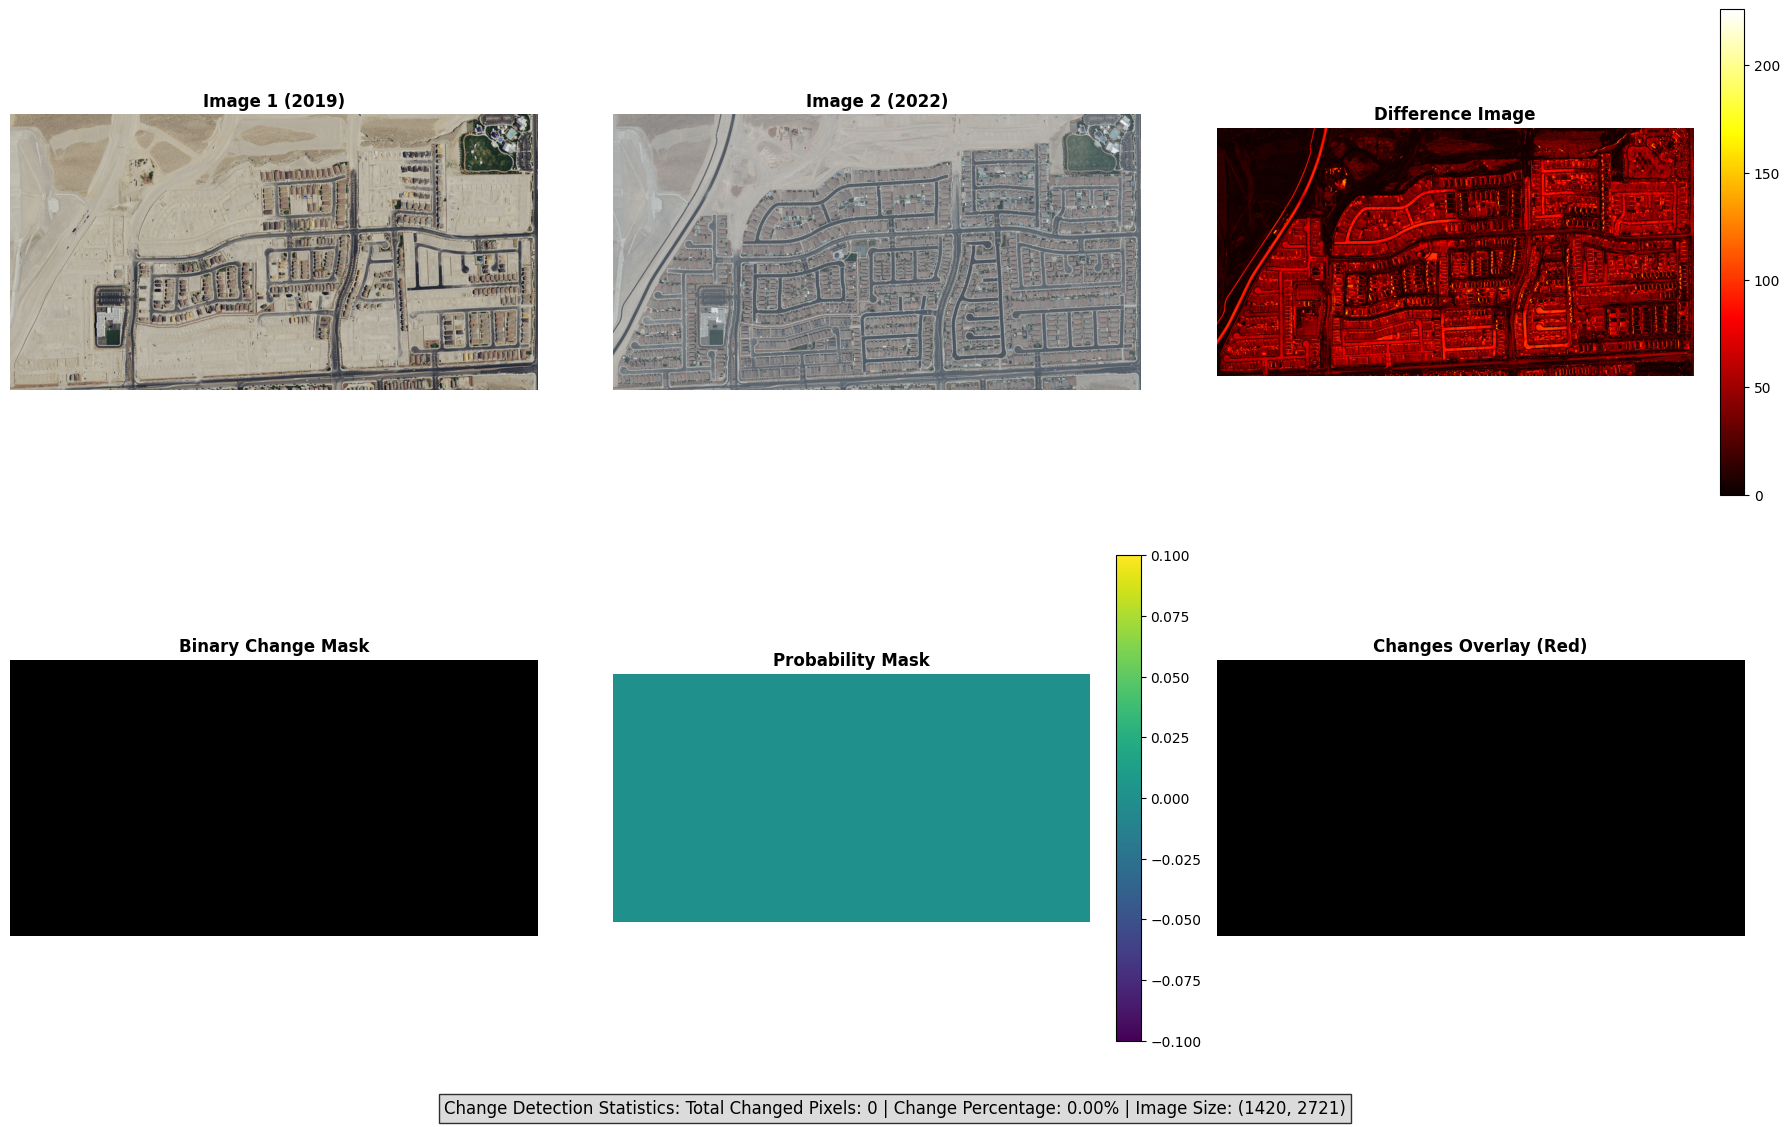

In [11]:
# # probability visualization
# detector.visualize_results(
#     naip_2019_path,
#     naip_2022_path,
#     f"{out_folder}/binary_mask.tif",
#     f"{out_folder}/probability_mask.tif",
# )

# Then visualize the results
print("\nVisualizing results...")
detector.visualize_results(
    naip_2019_path,
    naip_2022_path,
    f"{out_folder}/binary_mask.tif",
    f"{out_folder}/probability_mask.tif",
)

![](https://github.com/user-attachments/assets/e7c00b50-c456-4653-b8ce-0c9ec8f05b7f)

In [12]:
# Create split comparison visualization
detector.create_split_comparison(
    naip_2019_path,
    naip_2022_path,
    f"{out_folder}/binary_mask.tif",
    f"{out_folder}/probability_mask.tif",
    f"{out_folder}/split_comparison.png",
)

AttributeError: 'SimpleChangeDetector' object has no attribute 'create_split_comparison'

In [ ]:
# Analyze individual instances
instance_stats = detector.analyze_instances(
    f"{out_folder}/instance_masks.tif",
    f"{out_folder}/instance_masks_scores.tif",
    f"{out_folder}/instance_analysis.png",
)

![](https://github.com/user-attachments/assets/ea1f8a51-ea14-415a-9733-78b243061dd3)

## Comprehensive Analysis Report

Generate a detailed analysis report combining all metrics.

In [ ]:
# Create comprehensive analysis report
detector.create_comprehensive_report(results, f"{out_folder}/comprehensive_report.png")

![](https://github.com/user-attachments/assets/629caf85-0713-4e04-8023-f4273edbbb4c)

## One-Click Complete Analysis

For ultimate simplicity, use the complete analysis method.

In [23]:
# Alternative: Run complete analysis in one step
# This method does everything - detection, file outputs, and all visualizations
complete_results = detector.run_complete_analysis(
    naip_2019_path, naip_2022_path, "complete_analysis_results"
)

AttributeError: 'SimpleChangeDetector' object has no attribute 'run_complete_analysis'

In [3]:
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import rasterio
from rasterio.transform import from_bounds
import torch
from pathlib import Path
import urllib.request
import cv2
from typing import Dict, List, Optional, Tuple
import json

class SimpleChangeDetector:
    def __init__(self, sam_model_type="vit_h"):
        # Download checkpoint if needed
        cache_dir = Path("~/.cache/torch/hub/checkpoints/").expanduser()
        cache_dir.mkdir(parents=True, exist_ok=True)

        checkpoint_path = cache_dir / f"sam_{sam_model_type}.pth"
        if not checkpoint_path.exists():
            self._download_sam_checkpoint(sam_model_type, checkpoint_path)

        self.sam_model = sam_model_registry[sam_model_type](checkpoint=checkpoint_path)
        self.predictor = SamPredictor(self.sam_model)

        # Default parameters
        self.hyperparameters = {}
        self.mask_params = {}

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.sam_model.to(self.device)

    def _download_sam_checkpoint(self, model_type, path):
        model_urls = {
            "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
            "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
            "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
        }
        print(f"Downloading SAM {model_type} model...")
        urllib.request.urlretrieve(model_urls[model_type], path)

    def set_hyperparameters(self, **kwargs):
        self.hyperparameters = kwargs

    def set_mask_generator_params(self, **kwargs):
        self.mask_params = kwargs

    def _load_image(self, image_path: str) -> np.ndarray:
        """Load image using rasterio for geospatial data or OpenCV for regular images"""
        try:
            # Try rasterio first for geospatial data
            with rasterio.open(image_path) as src:
                image = src.read()
                # Convert to RGB if multi-band
                if image.shape[0] > 3:
                    image = image[:3]  # Take first 3 bands
                elif image.shape[0] == 1:
                    image = np.stack([image[0]] * 3, axis=0)  # Convert to 3-channel

                image = np.transpose(image, (1, 2, 0))  # HWC format
                self.geotransform = src.transform
                self.crs = src.crs
                return image
        except:
            # Fallback to OpenCV for regular images
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.geotransform = None
            self.crs = None
            return image

    def _preprocess_images(self, image1: np.ndarray, image2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Preprocess images for change detection"""
        # Resize images to same size if needed
        if image1.shape != image2.shape:
            h, w = min(image1.shape[0], image2.shape[0]), min(image1.shape[1], image2.shape[1])
            image1 = cv2.resize(image1, (w, h))
            image2 = cv2.resize(image2, (w, h))

        # Normalize to [0, 1]
        image1 = image1.astype(np.float32) / 255.0
        image2 = image2.astype(np.float32) / 255.0

        return image1, image2

    def _compute_difference(self, image1: np.ndarray, image2: np.ndarray) -> np.ndarray:
        """Compute difference between two images"""
        # Convert to grayscale for difference calculation
        gray1 = cv2.cvtColor((image1 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor((image2 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Compute absolute difference
        diff = cv2.absdiff(gray1, gray2)

        # Apply threshold from hyperparameters
        threshold = self.hyperparameters.get('change_confidence_threshold', 145)
        binary_diff = (diff > threshold).astype(np.uint8) * 255

        return binary_diff

    def _generate_masks(self, image: np.ndarray, difference_mask: np.ndarray) -> List[Dict]:
        """Generate masks using SAM for changed regions"""
        # Set image for SAM predictor
        self.predictor.set_image(image)

        # Find contours in difference mask
        contours, _ = cv2.findContours(difference_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        masks = []
        for i, contour in enumerate(contours):
            if cv2.contourArea(contour) < 100:  # Filter small contours
                continue

            # Get bounding box from contour
            x, y, w, h = cv2.boundingRect(contour)

            # Generate mask using SAM
            input_box = np.array([x, y, x + w, y + h])
            masks_data, scores, _ = self.predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True,
            )

            # Use the best mask
            best_idx = np.argmax(scores)
            mask = masks_data[best_idx]
            score = scores[best_idx]

            # Apply stability score threshold
            stability_thresh = self.mask_params.get('stability_score_thresh', 0.95)
            if score > stability_thresh:
                masks.append({
                    'mask': mask,
                    'score': score,
                    'bbox': [x, y, w, h],
                    'area': np.sum(mask),
                    'contour': contour
                })

        return masks

    def _save_geotiff(self, data: np.ndarray, output_path: str, transform, crs):
        """Save data as GeoTIFF with proper georeferencing"""
        if len(data.shape) == 2:
            data = data[np.newaxis, :, :]  # Add channel dimension

        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=str(data.dtype),
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(data)

    def detect_changes(self,
                      image1_path: str,
                      image2_path: str,
                      output_path: Optional[str] = None,
                      export_probability: bool = False,
                      probability_output_path: Optional[str] = None,
                      export_instance_masks: bool = False,
                      instance_masks_output_path: Optional[str] = None,
                      return_detailed_results: bool = True,
                      return_results: bool = True) -> Dict:

        print("Loading images...")
        image1 = self._load_image(image1_path)
        image2 = self._load_image(image2_path)

        print("Preprocessing images...")
        image1_proc, image2_proc = self._preprocess_images(image1, image2)

        print("Computing difference...")
        difference_mask = self._compute_difference(image1_proc, image2_proc)

        print("Generating masks for changed regions...")
        masks = self._generate_masks(image1_proc, difference_mask)

        # Create binary mask from all instance masks
        binary_mask = np.zeros(image1_proc.shape[:2], dtype=np.uint8)
        probability_mask = np.zeros(image1_proc.shape[:2], dtype=np.float32)

        for mask_data in masks:
            binary_mask[mask_data['mask']] = 255
            probability_mask[mask_data['mask']] = max(probability_mask[mask_data['mask']].max(), mask_data['score'])

        # Export results
        if output_path and self.geotransform is not None:
            print(f"Exporting binary mask to {output_path}")
            self._save_geotiff(binary_mask, output_path, self.geotransform, self.crs)

        if export_probability and probability_output_path and self.geotransform is not None:
            print(f"Exporting probability mask to {probability_output_path}")
            self._save_geotiff(probability_mask, probability_output_path, self.geotransform, self.crs)

        if export_instance_masks and instance_masks_output_path:
            print(f"Exporting instance masks to {instance_masks_output_path}")
            instance_mask = np.zeros(image1_proc.shape[:2], dtype=np.uint8)
            for i, mask_data in enumerate(masks):
                instance_mask[mask_data['mask']] = i + 1

            if self.geotransform is not None:
                self._save_geotiff(instance_mask, instance_masks_output_path, self.geotransform, self.crs)

        # Prepare results
        results = {
            'summary': {
                'total_masks': len(masks),
                'original_shape': image1_proc.shape[:2],
                'total_changed_pixels': np.sum(binary_mask > 0),
                'change_percentage': (np.sum(binary_mask > 0) / binary_mask.size) * 100
            },
            'masks': masks,
            'binary_mask': binary_mask,
            'probability_mask': probability_mask
        }

        if return_detailed_results:
            results['detailed_masks'] = [
                {
                    'id': i,
                    'score': mask_data['score'],
                    'area': mask_data['area'],
                    'bbox': mask_data['bbox']
                }
                for i, mask_data in enumerate(masks)
            ]

        print("Change detection completed!")
        return results if return_results else None

# Usage example
if __name__ == "__main__":
    # Make sure model directory exists
    Path("~/.cache/torch/hub/checkpoints/").expanduser().mkdir(parents=True, exist_ok=True)

    # Initialize change detection
    detector = SimpleChangeDetector(sam_model_type="vit_h")

    # Configure parameters
    detector.set_hyperparameters(
        change_confidence_threshold=145,
        use_normalized_feature=True,
        bitemporal_match=True,
    )

    detector.set_mask_generator_params(
        points_per_side=32,
        stability_score_thresh=0.95,
    )

    print("Change detection system initialized!")

    # Define your paths
    naip_2019_path = "/content/las_vegas_naip_2019_a.tif"
    naip_2022_path = "/content/las_vegas_naip_2022_a.tif"
    out_folder = "/content/change_detection_results"

    # Run change detection
    results = detector.detect_changes(
        naip_2019_path,
        naip_2022_path,
        output_path=f"{out_folder}/binary_mask.tif",
        export_probability=True,
        probability_output_path=f"{out_folder}/probability_mask.tif",
        export_instance_masks=True,
        instance_masks_output_path=f"{out_folder}/instance_masks.tif",
        return_detailed_results=True,
        return_results=True,
    )

    print(f"Change detection completed!")
    print(f"Total instances detected: {results['summary']['total_masks']}")
    print(f"Image size: {results['summary']['original_shape']}")
    print(f"Changed pixels: {results['summary']['total_changed_pixels']}")
    print(f"Change percentage: {results['summary']['change_percentage']:.2f}%")

Change detection system initialized!
Loading images...
Preprocessing images...
Computing difference...
Generating masks for changed regions...
Exporting binary mask to /content/change_detection_results/binary_mask.tif
Exporting probability mask to /content/change_detection_results/probability_mask.tif
Exporting instance masks to /content/change_detection_results/instance_masks.tif
Change detection completed!
Change detection completed!
Total instances detected: 0
Image size: (1420, 2721)
Changed pixels: 0
Change percentage: 0.00%


In [14]:
!pip install rasterio numpy scikit-image geopandas matplotlib shapely

In [20]:
import rasterio
import numpy as np
import geopandas as gpd
from skimage import exposure, filters
from shapely.geometry import shape, Polygon
import json
from rasterio import features
from rasterio.warp import calculate_default_transform, reproject, Resampling

def preprocess_images(img1_path, img2_path):
    """Preprocess and align two geotiff images"""
    with rasterio.open(img1_path) as src1, rasterio.open(img2_path) as src2:
        # Ensure both images have the same CRS and resolution
        if src1.crs != src2.crs:
            print("Warning: CRS mismatch. Reprojecting image 2 to match image 1...")
            # Reproject img2 to match img1
            transform, width, height = calculate_default_transform(
                src2.crs, src1.crs, src2.width, src2.height, *src2.bounds
            )
            kwargs = src2.meta.copy()
            kwargs.update({
                'crs': src1.crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            # Temporary reprojected image
            img2_reprojected = np.zeros((src2.count, height, width), dtype=src2.dtypes[0])
            reproject(
                source=rasterio.band(src2, 1),
                destination=img2_reprojected,
                src_transform=src2.transform,
                src_crs=src2.crs,
                dst_transform=transform,
                dst_crs=src1.crs,
                resampling=Resampling.bilinear
            )

            img1 = src1.read(1)  # Read first band
            img2 = img2_reprojected[0]
            profile = src1.profile
        else:
            img1 = src1.read(1)
            img2 = src2.read(1)
            profile = src1.profile

    # Normalize images
    img1_normalized = exposure.equalize_hist(img1)
    img2_normalized = exposure.equalize_hist(img2)

    return img1_normalized, img2_normalized, profile

def calculate_change_mask(img1, img2, method='difference', threshold=0.2):
    """Calculate change mask using different methods"""

    if method == 'difference':
        # Simple pixel difference
        diff = np.abs(img1.astype(float) - img2.astype(float))
        change_mask = diff > (threshold * np.max(diff))

    elif method == 'ratio':
        # Ratio method (good for reflectance data)
        ratio = np.where(img2 != 0, img1.astype(float) / img2.astype(float), 1)
        ratio = np.clip(ratio, 0.1, 10)  # Avoid extreme values
        change_mask = np.abs(ratio - 1) > threshold

    elif method == 'ndvi':
        # If you have multi-band data, you could calculate NDVI difference
        # This is a placeholder - adapt based on your data
        diff = np.abs(img1 - img2)
        change_mask = diff > (threshold * np.max(diff))

    # Apply morphological operations to clean up the mask
    from skimage import morphology
    change_mask = morphology.remove_small_objects(change_mask, min_size=50)
    change_mask = morphology.remove_small_holes(change_mask, area_threshold=50)

    return change_mask

def mask_to_geojson(change_mask, profile, output_path, simplify_tolerance=2.0):
    """Convert change mask to GeoJSON polygons"""

    # Create shapes from the mask
    shapes = features.shapes(change_mask.astype(np.uint8),
                            mask=change_mask,
                            transform=profile['transform'])

    # Convert to GeoJSON features
    features_list = []
    for geom, value in shapes:
        if value == 1:  # Changed areas
            polygon = shape(geom)

            # Simplify polygon to reduce file size
            if simplify_tolerance > 0:
                polygon = polygon.simplify(simplify_tolerance)

            # Only include polygons above minimum area
            if polygon.area > 100:  # Minimum area threshold
                feature = {
                    "type": "Feature",
                    "geometry": polygon.__geo_interface__,
                    "properties": {
                        "change_type": "detected",
                        "area_sq_m": polygon.area * (profile['transform'][0] ** 2)
                    }
                }
                features_list.append(feature)

    # Create GeoJSON structure
    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": f"EPSG:{profile['crs'].to_epsg()}"
            }
        },
        "features": features_list
    }

    # Save to file
    with open(output_path, 'w') as f:
        json.dump(geojson, f, indent=2)

    return geojson

def detect_change_areas(img1_path, img2_path, output_geojson_path,
                       method='difference', threshold=0.2):
    """
    Main function to detect changes between two geotiff images

    Parameters:
    - img1_path: Path to first geotiff
    - img2_path: Path to second geotiff
    - output_geojson_path: Output GeoJSON path
    - method: Change detection method ('difference', 'ratio', 'ndvi')
    - threshold: Sensitivity threshold (0-1)
    """

    print("Loading and preprocessing images...")
    img1, img2, profile = preprocess_images(img1_path, img2_path)

    print("Calculating change mask...")
    change_mask = calculate_change_mask(img1, img2, method, threshold)

    print(f"Detected {np.sum(change_mask)} changed pixels")

    print("Converting to GeoJSON...")
    geojson = mask_to_geojson(change_mask, profile, output_geojson_path)

    print(f"Change detection complete! Results saved to {output_geojson_path}")
    print(f"Found {len(geojson['features'])} changed areas")

    return geojson

# Example usage
if __name__ == "__main__":
    # Paths to your geotiff files
    image1_path = "/content/las_vegas_naip_2019_a.tif"
    image2_path = "/content/las_vegas_naip_2022_a.tif"
    output_path = "change_detection_results.geojson"

    # Run change detection
    results = detect_change_areas(
        img1_path=image1_path,
        img2_path=image2_path,
        output_geojson_path=output_path,
        method='difference',  # Try 'ratio' for reflectance data
        threshold=0.15  # Adjust based on your needs
    )

Loading and preprocessing images...
Calculating change mask...
Detected 2560135 changed pixels
Converting to GeoJSON...
Change detection complete! Results saved to change_detection_results.geojson
Found 97 changed areas


In [21]:
import geopandas as gpd
import json

def convert_geojson_26911_to_4326(input_geojson_path, output_geojson_path):
    """
    Convert GeoJSON from EPSG:26911 to EPSG:4326

    Parameters:
    - input_geojson_path: Path to input GeoJSON (EPSG:26911)
    - output_geojson_path: Path to output GeoJSON (EPSG:4326)
    """

    # Read the GeoJSON file
    gdf = gpd.read_file(input_geojson_path)

    # Check current CRS
    print(f"Input CRS: {gdf.crs}")

    # Reproject to EPSG:4326 (WGS84)
    gdf_4326 = gdf.to_crs('EPSG:4326')

    # Save as GeoJSON
    gdf_4326.to_file(output_geojson_path, driver='GeoJSON')

    print(f"Conversion complete! Output saved to: {output_geojson_path}")
    print(f"Output CRS: {gdf_4326.crs}")

# Usage
convert_geojson_26911_to_4326(
    "change_detection_results.geojson",
    "change_detection_results_4326.geojson"
)

Input CRS: EPSG:26911
Conversion complete! Output saved to: change_detection_results_4326.geojson
Output CRS: EPSG:4326


In [19]:
# import rasterio
# import numpy as np
# import geopandas as gpd
# from skimage import exposure, filters
# from shapely.geometry import shape, Polygon
# import json
# from rasterio import features
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# from rasterio.crs import CRS

# def preprocess_images(img1_path, img2_path, target_crs='EPSG:4326'):
#     """Preprocess and align two geotiff images to target CRS"""
#     target_crs_obj = CRS.from_string(target_crs)

#     with rasterio.open(img1_path) as src1, rasterio.open(img2_path) as src2:
#         # Reproject both images to target CRS if needed
#         if src1.crs != target_crs_obj:
#             print(f"Reprojecting image 1 to {target_crs}...")
#             transform1, width1, height1 = calculate_default_transform(
#                 src1.crs, target_crs_obj, src1.width, src1.height, *src1.bounds
#             )
#             img1_reprojected = np.zeros((src1.count, height1, width1), dtype=src1.dtypes[0])
#             reproject(
#                 source=rasterio.band(src1, 1),
#                 destination=img1_reprojected,
#                 src_transform=src1.transform,
#                 src_crs=src1.crs,
#                 dst_transform=transform1,
#                 dst_crs=target_crs_obj,
#                 resampling=Resampling.bilinear
#             )
#             img1 = img1_reprojected[0]
#             profile1 = src1.profile.copy()
#             profile1.update({
#                 'crs': target_crs_obj,
#                 'transform': transform1,
#                 'width': width1,
#                 'height': height1
#             })
#         else:
#             img1 = src1.read(1)
#             profile1 = src1.profile

#         if src2.crs != target_crs_obj:
#             print(f"Reprojecting image 2 to {target_crs}...")
#             transform2, width2, height2 = calculate_default_transform(
#                 src2.crs, target_crs_obj, src2.width, src2.height, *src2.bounds
#             )
#             img2_reprojected = np.zeros((src2.count, height2, width2), dtype=src2.dtypes[0])
#             reproject(
#                 source=rasterio.band(src2, 1),
#                 destination=img2_reprojected,
#                 src_transform=src2.transform,
#                 src_crs=src2.crs,
#                 dst_transform=transform2,
#                 dst_crs=target_crs_obj,
#                 resampling=Resampling.bilinear
#             )
#             img2 = img2_reprojected[0]
#             profile2 = src2.profile.copy()
#             profile2.update({
#                 'crs': target_crs_obj,
#                 'transform': transform2,
#                 'width': width2,
#                 'height': height2
#             })
#         else:
#             img2 = src2.read(1)
#             profile2 = src2.profile

#         # Ensure both images have same dimensions (resample to common grid if needed)
#         if img1.shape != img2.shape:
#             print("Resampling images to common grid...")
#             # Use the larger dimensions as reference
#             target_height = max(img1.shape[0], img2.shape[0])
#             target_width = max(img1.shape[1], img2.shape[1])

#             # Resample img1 if needed
#             if img1.shape != (target_height, target_width):
#                 from skimage.transform import resize
#                 img1 = resize(img1, (target_height, target_width), preserve_range=True)
#                 profile1.update({
#                     'width': target_width,
#                     'height': target_height
#                 })

#             # Resample img2 if needed
#             if img2.shape != (target_height, target_width):
#                 from skimage.transform import resize
#                 img2 = resize(img2, (target_height, target_width), preserve_range=True)
#                 profile2.update({
#                     'width': target_width,
#                     'height': target_height
#                 })

#         # Use profile1 as the reference profile (both should have same CRS now)
#         profile = profile1

#     # Normalize images
#     img1_normalized = exposure.equalize_hist(img1)
#     img2_normalized = exposure.equalize_hist(img2)

#     return img1_normalized, img2_normalized, profile

# def calculate_change_mask(img1, img2, method='difference', threshold=0.2):
#     """Calculate change mask using different methods"""

#     if method == 'difference':
#         # Simple pixel difference
#         diff = np.abs(img1.astype(float) - img2.astype(float))
#         change_mask = diff > (threshold * np.max(diff))

#     elif method == 'ratio':
#         # Ratio method (good for reflectance data)
#         ratio = np.where(img2 != 0, img1.astype(float) / img2.astype(float), 1)
#         ratio = np.clip(ratio, 0.1, 10)  # Avoid extreme values
#         change_mask = np.abs(ratio - 1) > threshold

#     elif method == 'ndvi':
#         # If you have multi-band data, you could calculate NDVI difference
#         # This is a placeholder - adapt based on your data
#         diff = np.abs(img1 - img2)
#         change_mask = diff > (threshold * np.max(diff))

#     # Apply morphological operations to clean up the mask
#     from skimage import morphology
#     change_mask = morphology.remove_small_objects(change_mask, min_size=50)
#     change_mask = morphology.remove_small_holes(change_mask, area_threshold=50)

#     return change_mask

# def mask_to_geojson(change_mask, profile, output_path, simplify_tolerance=2.0):
#     """Convert change mask to GeoJSON polygons in EPSG:26911"""

#     # Create shapes from the mask
#     shapes = features.shapes(change_mask.astype(np.uint8),
#                             mask=change_mask,
#                             transform=profile['transform'])

#     # Convert to GeoJSON features
#     features_list = []
#     for geom, value in shapes:
#         if value == 1:  # Changed areas
#             polygon = shape(geom)

#             # Simplify polygon to reduce file size
#             if simplify_tolerance > 0:
#                 polygon = polygon.simplify(simplify_tolerance)

#             # Only include polygons above minimum area
#             if polygon.area > 100:  # Minimum area threshold
#                 # Calculate area in square meters
#                 pixel_size_x = profile['transform'][0]
#                 pixel_size_y = -profile['transform'][4]  # Typically negative for north-up images
#                 area_sq_m = polygon.area * (pixel_size_x * pixel_size_y)

#                 feature = {
#                     "type": "Feature",
#                     "geometry": polygon.__geo_interface__,
#                     "properties": {
#                         "change_type": "detected",
#                         "area_sq_m": round(area_sq_m, 2)
#                     }
#                 }
#                 features_list.append(feature)

#     # Create GeoJSON structure with EPSG:4326 CRS
#     geojson = {
#         "type": "FeatureCollection",
#         "crs": {
#             "type": "name",
#             "properties": {
#                 "name": "EPSG:4326"
#             }
#         },
#         "features": features_list
#     }

#     # Save to file
#     with open(output_path, 'w') as f:
#         json.dump(geojson, f, indent=2)

#     return geojson

# def detect_change_areas(img1_path, img2_path, output_geojson_path,
#                        method='difference', threshold=0.2, target_crs='EPSG:4326'):
#     """
#     Main function to detect changes between two geotiff images

#     Parameters:
#     - img1_path: Path to first geotiff
#     - img2_path: Path to second geotiff
#     - output_geojson_path: Output GeoJSON path
#     - method: Change detection method ('difference', 'ratio', 'ndvi')
#     - threshold: Sensitivity threshold (0-1)
#     - target_crs: Target coordinate reference system (default: EPSG:4326)
#     """

#     print("Loading and preprocessing images...")
#     img1, img2, profile = preprocess_images(img1_path, img2_path, target_crs)

#     print(f"Image shape: {img1.shape}")
#     print(f"CRS: {profile['crs']}")

#     print("Calculating change mask...")
#     change_mask = calculate_change_mask(img1, img2, method, threshold)

#     print(f"Detected {np.sum(change_mask)} changed pixels")

#     print("Converting to GeoJSON...")
#     geojson = mask_to_geojson(change_mask, profile, output_geojson_path)

#     print(f"Change detection complete! Results saved to {output_geojson_path}")
#     print(f"Found {len(geojson['features'])} changed areas")

#     # Print CRS information
#     print(f"Output GeoJSON CRS: {geojson['crs']['properties']['name']}")

#     return geojson

# # Alternative function using geopandas for additional CRS control
# def ensure_geojson_crs(geojson_path, target_crs='EPSG:4326'):
#     """Ensure the GeoJSON file has the correct CRS using geopandas"""
#     gdf = gpd.read_file(geojson_path)

#     # If CRS is not set or different, set it to target CRS
#     if gdf.crs is None or gdf.crs != target_crs:
#         gdf = gdf.set_crs(target_crs, allow_override=True)

#     # Save back to GeoJSON
#     gdf.to_file(geojson_path, driver='GeoJSON')
#     print(f"Verified and set CRS to {target_crs}")

# # Example usage
# if __name__ == "__main__":
#     # Paths to your geotiff files
#     image1_path = "/content/las_vegas_naip_2019_a.tif"
#     image2_path = "/content/las_vegas_naip_2022_a.tif"
#     output_path = "change_detection_results.geojson"

#     # Run change detection with EPSG:4326 output
#     results = detect_change_areas(
#         img1_path=image1_path,
#         img2_path=image2_path,
#         output_geojson_path=output_path,
#         method='difference',
#         threshold=0.15,
#         target_crs='EPSG:4326'
#     )

#     # Optional: Double-check CRS using geopandas
#     ensure_geojson_crs(output_path, 'EPSG:4326')

#     print("GeoJSON successfully created in EPSG:4326 format!")

Loading and preprocessing images...
Reprojecting image 1 to EPSG:4326...
Reprojecting image 2 to EPSG:4326...
Image shape: (1237, 2860)
CRS: EPSG:4326
Calculating change mask...
Detected 2234374 changed pixels
Converting to GeoJSON...
Change detection complete! Results saved to change_detection_results.geojson
Found 0 changed areas
Output GeoJSON CRS: EPSG:4326
Verified and set CRS to EPSG:4326
GeoJSON successfully created in EPSG:4326 format!


In [23]:
import json

def json_to_geojson(input_json_path, output_geojson_path):
    # Load input JSON
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    # Define GeoJSON template
    geojson = data

    # Example: Convert each record with lat/lon to GeoJSON Point
    for item in data:
        if "latitude" in item and "longitude" in item:
            feature = {
                "type": "Feature",
                "properties": {k: v for k, v in item.items() if k not in ["latitude", "longitude"]},
                "geometry": {
                    "type": "Point",
                    "coordinates": [item["longitude"], item["latitude"]]
                }
            }
            geojson["features"].append(feature)

    # Save to GeoJSON file
    with open(output_geojson_path, 'w') as f:
        json.dump(geojson, f, indent=4)

    print(f"✅ GeoJSON saved to {output_geojson_path}")

# Example usage
json_to_geojson("/content/response_1762173040967.json", "output.geojson")


✅ GeoJSON saved to output.geojson


## Summary

This notebook demonstrated the change detection functionality in GeoAI with integrated visualization methods:

### Key Features Used:
1. **Change Detection**: Instance segmentation with confidence scoring
2. **Integrated Visualizations**: Built-in methods for comprehensive analysis
3. **Simplified API**: Clean, streamlined interface following geoai patterns
4. **Complete Analysis**: One-click method for full analysis workflow

### Output Files Generated:
- `binary_mask.tif`: Traditional binary change detection
- `probability_mask.tif`: Probability-weighted change detection  
- `instance_masks.tif`: Instance segmentation with unique IDs
- `instance_masks_scores.tif`: Confidence scores for each instance
- `enhanced_probability_results.png`: Comprehensive visualization
- `split_comparison.png`: Before/after split comparison
- `instance_analysis.png`: Individual instance analysis
- `comprehensive_report.png`: Complete analysis report

### Advantages Over Traditional Methods:
1. **Instance-Level Analysis**: Each change object has unique ID and metrics
2. **Quality Assessment**: Confidence scores for filtering and ranking
3. **Rich Visualizations**: Multiple analysis perspectives in one package
4. **Simplified Workflow**: Integrated methods reduce code complexity
5. **Flexible Usage**: From simple detection to comprehensive analysis

In [24]:
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

# Load Sentinel-2 bands
with rasterio.open("B08.tif") as nir, rasterio.open("B04.tif") as red:
    nir_band = nir.read(1).astype(float)
    red_band = red.read(1).astype(float)

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-5)

# Threshold for vegetation
green_mask = ndvi > 0.3

plt.figure(figsize=(10,6))
plt.imshow(green_mask, cmap='Greens')
plt.title("Detected Green Areas")
plt.axis('off')
plt.show()


RasterioIOError: B08.tif: No such file or directory